# Intro

The goal of this document is to explore the code within RITSAR with regard to point target simulation and give step by step visualization to the ongoing processes.  

In [1]:
#Generic Import statements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook
from scipy.constants import c #import speed of light

# Defining the SAR platform


In [2]:
#Define platform parameters
f_0 = 10.0e9   #center frequency in Hz
wvl = c/f_0   #center wavelength in meters
print('center wavelength in meters: ', wvl)
chirprate = 4.8e12 #chirprate in Hz per sec
T_p = 38.5e-6 # pulse length in seconds
B = T_p*chirprate # pulse bandwidth in Hz
AD_sampling = 45.0e6 #analog to digital sample rate in Hz
delta_t = 1.0/AD_sampling #time between two samples
print('Time between samples: ', delta_t)
nsamples = 2048 #number of samples per pulse
npulses = 1950 #number of pulses
squint = np.pi/2 #look direction off platform velocity in x,y plane (radians)
graze = 30*np.pi/180 #look direction off x,y plane (radians)

center wavelength in meters:  0.0299792458
Time between samples:  2.2222222222222224e-08


<IPython.core.display.Javascript object>


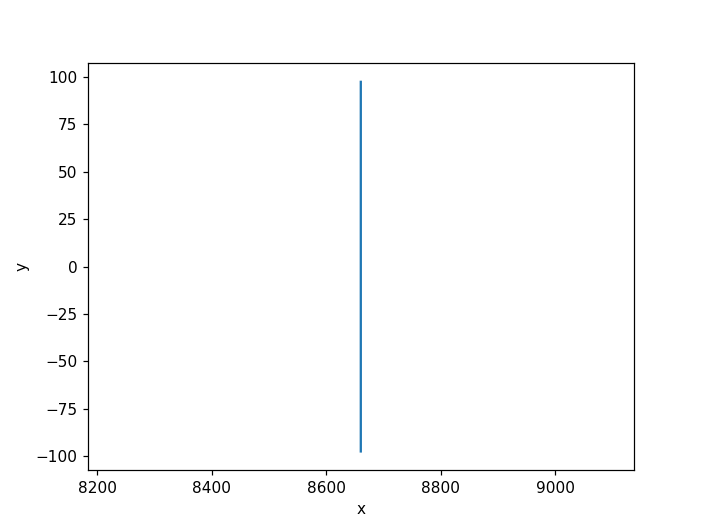

Text(0, 0.5, 'y')

In [3]:
#Define platform position
    
#x
R0_apCenter = 10000.0
Xc = R0_apCenter*np.cos(graze)
    
#y
prf = 1000.0
v_p = 100.0
dy = v_p/prf
Y_c = Xc*np.tan(np.pi/2-squint)
y = np.linspace(-npulses/2, npulses/2, npulses)*dy+Y_c
    
#z    
h = 5000.0
    
#r[npulses , (x,y,z)]
pos = np.zeros([npulses, 3])
pos[:,0] = Xc
pos[:,1] = y
pos[:,2] = h

fig,ax=plt.subplots()
ax.plot(pos[:,0],pos[:,1],label='pos')
ax.set_xlabel('x')
ax.set_ylabel('y')



In [4]:
#Synthetic aperture length
L = np.linalg.norm(pos[-1]-pos[0])
    
#Vector to scene center at synthetic aperture center
if np.mod(npulses,2)>0: #if npulses odd, return center position
    R_c = pos[npulses//2] 
else: #if npulses even, average center two
    R_c = np.mean(pos[npulses//2-1:npulses//2+1],axis = 0) #Note: python doesn't include the last indexed element
    

print('length of array: %f' %L)
print('Array Center in cartesian coordinates: ', R_c)
    

length of array: 195.000000
Array Center in cartesian coordinates:  [8.66025404e+03 5.68295411e-15 5.00000000e+03]


[see TODO] Integration angle between first and last pulse position(degrees): 1.117232299104403


<IPython.core.display.Javascript object>


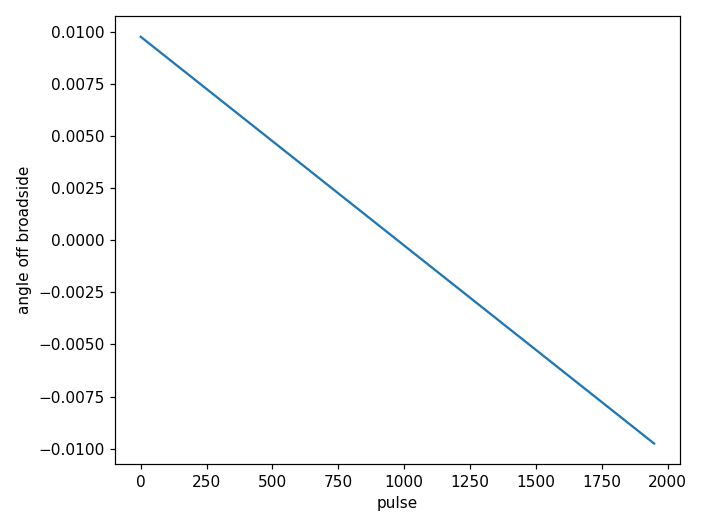

In [5]:
#Coherent integration angle
#TODO: Fix this calculation because it doesn't account for the wide angle SAR case, flying circle around target
p1_hat = pos[0]/np.linalg.norm(pos[0]) #First pulse unit vector from scene center
p2_hat = pos[-1]/np.linalg.norm(pos[-1]) #last pulse unit vector from scene center
Delta_theta = np.arccos(np.dot(p1_hat, p2_hat)) #angle between first and last pulse unit vectors
print('[see TODO] Integration angle between first and last pulse position(degrees):', Delta_theta*180/np.pi)

#Look angle w.r.t. velocity vector for each pulse (minus pi/2)
theta = np.zeros(npulses)
R_vel = pos[-1]-pos[0]
R_vel_norm = np.linalg.norm(R_vel)
for i in range(npulses):
    num = np.dot(pos[i], R_vel)
    den = np.linalg.norm(pos[i])*R_vel_norm
    theta[i] = np.arccos(num/den)-np.pi/2
    
fig, ax=plt.subplots()
ax.plot(np.arange(npulses), theta)
ax.set_xlabel('pulse')
ax.set_ylabel('angle off broadside') 
fig.tight_layout()


<IPython.core.display.Javascript object>


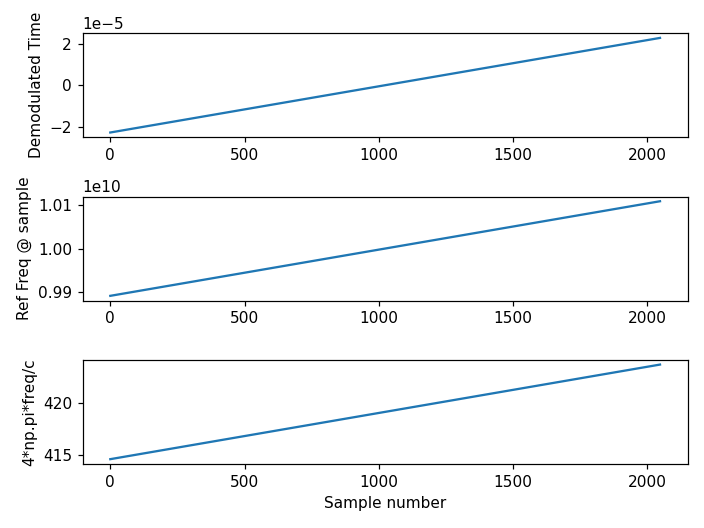

218453333.33333334
0.6861704818725586


In [6]:
#Obtain frequency locations of range samples
#Assuming demodulated linear FM signal
t = np.linspace(-nsamples/2, nsamples/2, nsamples)*delta_t #demodulated fast time (demod so we stay at baseband)
#TODO: figure out how to mismatch modulation and demodulation, I gotta see the effects
B_IF = (t.max()-t.min())*chirprate #highest frequency minus lowest frequency of reference
delta_r = c/(2*B_IF) #theoretical range resolution
freq = f_0+chirprate*t #associated frequency to each time sample
omega = 2*np.pi*freq #This is for omega-k image formation
k_r = 2*omega/c #definitely need this for polar formatting
k_y = np.linspace(-npulses/2,npulses/2,npulses)*2*np.pi/L #not sure why this is here

fig,ax=plt.subplots(3)
ax[0].plot(t)
ax[0].set_ylabel('Demodulated Time')
ax[1].plot(freq)
ax[1].set_ylabel('Ref Freq @ sample')
ax[2].plot(k_r)
ax[2].set_ylabel('4*np.pi*freq/c')
ax[2].set_xlabel('Sample number')
fig.tight_layout()
print(B_IF)
print(delta_r)


In [7]:
#Construct dictionary and return to caller
platform = \
{
    'f_0'       :   f_0,
    'wvl'       :   wvl,
    'chirprate' :   chirprate,
    'T_p'       :   T_p,
    'B'         :   B,
    'B_IF'      :   B_IF,
    'AD_sampling':  AD_sampling,
    'delta_t'   :   delta_t,
    'nsamples'  :   nsamples,
    'npulses'   :   npulses,
    'squint'    :   squint,
    'graze'     :   graze,
    'pos'       :   pos,
    'L'         :   L,
    'delta_r'   :   delta_r,
    'Delta_theta':  Delta_theta,
    'theta'     :   theta,
    'R_c'       :   R_c,
    't'         :   t,
    'freq'      :   freq,
    'omega'     :   omega,
    'k_r'       :   k_r,
    'k_y'       :   k_y
}
print(platform.keys())

dict_keys(['f_0', 'wvl', 'chirprate', 'T_p', 'B', 'B_IF', 'AD_sampling', 'delta_t', 'nsamples', 'npulses', 'squint', 'graze', 'pos', 'L', 'delta_r', 'Delta_theta', 'theta', 'R_c', 't', 'freq', 'omega', 'k_r', 'k_y'])


# Simulate Phase History

<IPython.core.display.Javascript object>


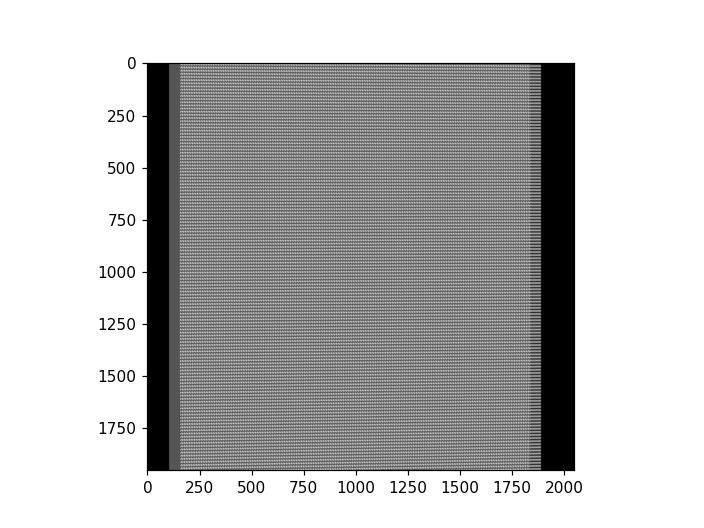

In [8]:
# points and amplitudes from function call
points = [[0,0,0],
          [0,-100,0],
          [200,0,0]]
amplitudes = [1,1,1]

#points=[[0,0,0]]
#amplitudes=[1]

# begin function internals
#Retrieve relevent parameters
gamma   =   platform['chirprate'] #why change names? todo: see what is the more standard name and keep one
f_0     =   platform['f_0']
t       =   platform['t']
pos     =   platform['pos']
npulses =   platform['npulses']
nsamples=   platform['nsamples']
T_p     =   platform['T_p']

#Todo, add the same print statement options from processing to this
#I don't want to print for every single pulse

def RECT(t,T):
    ''' 
    Function from signal file to give rect response in time
    
    Parameters
    ------------
    t : time of each sample, (shift done externally)
    T : pulse length in time
    
    Returns array like 't' which is 1 if t is within zero centered pulse length, 0 otherwise
    '''
    f = np.zeros(len(t))
    f[(t/T<0.5) & (t/T >-0.5)] = 1
    return f

#Simulate the phase history for each pulse, for each point
phs = np.zeros([npulses, nsamples])+0j #pre populate
for i in range(npulses):
    #print('simulating pulse %i'%(i+1)) #status statement
        
    R_0 = np.linalg.norm(pos[i]) #current range to scene center
    j=0 #feels kinda hacky but effective for amplitude of each point, consider changing
    for p in points: #could remove j by using enumerate to give index
            
        R_t = np.linalg.norm(pos[i]-p) #R_t is a bad name, R_p?
        dr  = R_t-R_0
        phase = np.pi*gamma*(2*dr/c)**2-2*np.pi*(f_0+gamma*t)*2*dr/c #todo: figure out stretch dependency
            
        phs[i,:] += amplitudes[j]*np.exp(1j*phase)*RECT((t-2*dr/c),T_p)
            
        j+=1 #move to the next point. I feel like this could be more parallel
        
#display phs
fig, ax = plt.subplots()
ax.imshow(np.abs(phs), cmap='gray')



# Create the image plane dictionary

This is arguably the most variable and important step. So I'm going to extend this a bit beyond the baseline tutorial and leave in the additional tunable knobs for image plane definition. Default will be the tutorial, but you'll see a lot that looks unused. 

This is also because I added pieces to this function that were not necessary and should have split my mods out separately.


In [9]:
def img_plane_dict(platform, n_hat = np.array([0,0,1]), numPixels=False, \
                   length=False, upsample=False, res_factor=False, \
                   aspect=False, checkme=False, force_xy=False):
    '''
    This function defines the image plane parameters.
    
    Parameters
    ----------
    platform  :  dict    
        The platform dictionary. Must include keys 'nsamples',
        'npulses', 'freq', 'R_c', 'pos' and if keyword `res_factor` is
        used 'delta_r'    
    n_hat  :  array, default=numpy.array([0,0,1])    
        Normal vector of the plane in which you wish to form the image    
    numPixels  :  int, array, tuple, or list. optional
        Allows the user to specify the number of pixels of the output image in
        range(nu) and cross range(nv) directions. int will result in a square.    
    length  :  int, array, tuple, or list. optional    
        Size (m) of scene to form image in range and cross range 
        directions (determined by center of aperture) about scene center.    
    upsample  :  bool, optional    
        Autodetermines image size by rounding nsamples and npulses up 
        to the nearest power of 2. Overridden by numPixels    
    res_factor  :  float, optional    
        A res_factor of 1 yields a (u,v) image plane whose pixels are 
        sized at the theoretical resolution limit of the system derived
        using delta_r which in turn was derived using the bandwidth.
        Using this or aspect will override `length`    
    aspect  :  float, optional    
        Using this will force a given aspect (dv/du) on the output image
        and will select the lower resolution (larger) between du and dv 
        at the given aspect. This will override length    
    checkme  :  bool, optional    
        Prints theoretical maximum scene size and resolution limits.
        Then prints chosen size and resolution limits.    
    force_xy  :  bool, optional    
        Used for comparison with matlab code. Forces u_vec=[1,0,0] and
        v_vec=[0,1,0]. Note that this overrides n_hat    

    Returns
    ----------
    output  :  dict    
        Contains keys: 'n_hat', 'u_hat', 'v_hat', 'du', 'dv', 'u', 'v', 'k_u',
        'k_v', and 'pixel_locs'. 
        
        'du'/'dv' (m) represents the spacing along 'u' and 'v' while 'u_hat' and 'v_hat' give their direction.
        'k_u' and 'k_v' (1/m) represent frequencies on the image plane. 
        'pixel_locs' is a 3x(nu,nv) array of xyz coordinates to use for sampling locations.    

    '''
    
    nsamples = platform['nsamples']
    npulses  = platform['npulses']
    freq     = platform['freq']

    if freq.ndim ==1:
        freq=freq[None,:]
    deltaF=freq[0,2]-freq[0,1] #assumes LFM chirp

    #Import relevant platform parameters
    R_c = platform['R_c']    
    def isany(x):
        isin=isinstance
        return np.any([isin(x,list),isin(x,np.ndarray),isin(x,tuple)])
    
    #Define image plane parameters
    if isany(numPixels):
        nu,nv=numPixels[0],numPixels[-1]
    elif np.all([isinstance(numPixels,int),numPixels>0]):
        nu,nv=numPixels,numPixels
    elif np.all([not numPixels,upsample]):
        nu= 2**int(np.log2(nsamples)+bool(np.mod(np.log2(nsamples),1)))
        nv= 2**int(np.log2(npulses)+bool(np.mod(np.log2(npulses),1)))
    else:
        nu,nv= nsamples,npulses
        
    #Determine scene bounds
    #todo: graze not taken into account?
    #todo: figure out what is needed here and pull out the rest to an external checkme
    # Determine the azimuth angles of the image pulses (radians)
    pos=platform['pos']
    AntAz = np.unwrap(np.arctan2(pos[:,1],pos[:,0])) 
    
    # Determine the average azimuth angle step size (radians)
    deltaAz = np.abs(np.mean(np.diff(AntAz)))

    # Determine the total azimuth angle of the aperture (radians)
    totalAz = np.max(AntAz) - np.min(AntAz) #todo: consider changing this to cumulative sum of np.diff(AntAz)

    # Determine the maximum scene size of the image (m)
    maxWr = c/(2*deltaF)
    maxWx = c/(2*deltaAz*np.mean(freq[0,:]))

    if isany(length):
        ulength,vlength=length[0],length[-1]
    elif np.all([isinstance(length,int),length>0]):
        ulength,vlength=length,length
    else:
        #todo: is 1.22 the right number?
        ulength,vlength=1.22*maxWr,1.22*maxWx #1.22 for Airy disk limit, will alias

    #Build Pixel Grid
    if res_factor: #included for compatibility
        #Define resolution.  This should be less than the system resolution limits
        res_factor=res_factor if res_factor else 1.0
        du = platform['delta_r']*res_factor*nsamples/nu
        aspect=aspect if aspect else 1.0
        dv = aspect*du
        #Define range and cross-range locations
        u = np.arange(-nu/2, nu/2)*du
        v = np.arange(-nv/2, nv/2)*dv
        ulength,vlength=np.abs(u[-1]-u[0]),np.abs(v[-1]-v[0])
    elif np.all([not res_factor, aspect]):
        ubound = 0.5*ulength*np.array([-1, 1]);
        vbound = 0.5*vlength*np.array([-1, 1]);
        du=np.max([ulength/nu,vlength/(aspect*nv)])
        dv=aspect*du
        #Define range and cross-range locations
        u = np.arange(-nu/2, nu/2)*du
        v = np.arange(-nv/2, nv/2)*dv
        ulength,vlength=np.abs(u[-1]-u[0]),np.abs(v[-1]-v[0])
    else:
        ubound = 0.5*ulength*np.array([-1, 1]);
        vbound = 0.5*vlength*np.array([-1, 1]);
        u = np.linspace(ubound[0],ubound[1],nu);
        v = np.linspace(vbound[0],vbound[1],nv);  
        du=u[2]-u[1]
        dv=v[2]-v[1]
    
    if checkme: #todo, remove checkme from this function and make it its own
        # Determine the resolution of the image (m)
        dr = c/(2*deltaF*nsamples);
        dx = c/(2*totalAz*np.mean(freq[0,:]));

        # Display maximum scene size and resolution
        print('Maximum Scene Size:  %.4f m range, %.4f m cross-range'%(maxWr,maxWx))
        print('Max Resolution:  %.4fm range, %.4f m cross-range'%(dr,dx))
        print('Chosen Size: %.4f m range %.4f m cross-range' %(ulength,vlength))
        print('Chosen Sample Spacing: %.4f m range, %.4f m cross-range'%(du,dv))

    #Derive image plane spatial frequencies
    k_u = 2*np.pi*np.linspace(-1.0/(2*du), 1.0/(2*du), nu)
    k_v = 2*np.pi*np.linspace(-1.0/(2*dv), 1.0/(2*dv), nv)

    if force_xy:
        u_hat=np.array([1,0,0])
        v_hat=np.array([0,1,0])
    else:
        #Derive representation of u_hat and v_hat in (x,y,z) space
        v_hat = np.cross(n_hat, R_c)/np.linalg.norm(np.cross(n_hat, R_c))
        u_hat = np.cross(v_hat, n_hat)/np.linalg.norm(np.cross(v_hat, n_hat))

    #Represent u and v in (x,y,z)
    #note: this isn't used in most image formation algos, just backprojection
    #todo: consider moving this into backprojection if it is only one needing it
    [uu,vv] = np.meshgrid(u,v)
    uu = uu.flatten(); vv = vv.flatten()

    A = np.asmatrix(np.hstack((
        np.array([u_hat]).T, np.array([v_hat]).T 
            ))) 
    b = np.asmatrix(np.vstack((uu,vv)))
    pixel_locs = np.asarray(A*b)

    #Construct dictionary and return to caller
    img_plane =\
        {
        'n_hat'     :   n_hat,
        'u_hat'     :   u_hat,
        'v_hat'     :   v_hat,
        'du'        :   du,
        'dv'        :   dv,
        'u'         :   u,
        'v'         :   v,
        'k_u'       :   k_u,
        'k_v'       :   k_v,
        'pixel_locs':   pixel_locs # 3 x N_pixel array specifying x,y,z location
                                   # of each pixel
        }
    
    return(img_plane)

#ToDo: put section at end that messes with this to show quick differences
#Create image plane dictionary
img_plane = img_plane_dict(platform, aspect = 1, checkme=True)



Maximum Scene Size:  1404.5910 m range, 1297.5285 m cross-range
Max Resolution:  0.6858m range, 0.6657 m cross-range
Chosen Size: 1712.7643 m range 1630.7658 m cross-range
Chosen Sample Spacing: 0.8367 m range, 0.8367 m cross-range


In [10]:
#parameters for my image plane function
n_hat = np.array([0,0,1]), 
numPixels=False
length=False
upsample=False
res_factor=False
aspect=False
checkme=False
force_xy=False
    
#Import relevant platform parameters
#nsamples = platform['nsamples']
#npulses  = platform['npulses']
#freq     = platform['freq']
#R_c = platform['R_c']  #already present in memory 
#pos=platform['pos']    #already present in memory 
if freq.ndim ==1:
    freq=freq[None,:] #todo: this was a bad idea, change it back
deltaF=freq[0,2]-freq[0,1] #assumes LFM chirp
#note, now freq is 2d, which isn't the greatest
def isany(x):
    isin=isinstance
    return np.any([isin(x,list),isin(x,np.ndarray),isin(x,tuple)])
    
#Define image plane parameters
if isany(numPixels):
    nu,nv=numPixels[0],numPixels[-1]
elif np.all([isinstance(numPixels,int),numPixels>0]):
    nu,nv=numPixels,numPixels
elif np.all([not numPixels,upsample]):
    nu= 2**int(np.log2(nsamples)+bool(np.mod(np.log2(nsamples),1)))
    nv= 2**int(np.log2(npulses)+bool(np.mod(np.log2(npulses),1)))
else:
    nu,nv= nsamples,npulses
    
print('nu: ', nu)
print('nv: ', nv)
    
    

nu:  2048
nv:  1950


In [11]:
#Determine scene bounds
#todo: graze not taken into account?
#todo: figure out what is needed here and pull out the rest to an external checkme
# Determine the azimuth angles of the image pulses (radians)

AntAz = np.unwrap(np.arctan2(pos[:,1],pos[:,0])) 
    
# Determine the average azimuth angle step size (radians)
deltaAz = np.abs(np.mean(np.diff(AntAz)))

# Determine the total azimuth angle of the aperture (radians)
totalAz = np.max(AntAz) - np.min(AntAz) #todo: consider changing this to cumulative sum of np.diff(AntAz)
    
# Determine the maximum scene size of the image (m)
maxWr = c/(2*deltaF)
maxWx = c/(2*deltaAz*np.mean(freq[0,:]))

print('maxWr: ', maxWr)
print('maxWx: ', maxWx)


maxWr:  1404.5909763892848
maxWx:  1297.528526342071


In [12]:
#choose length in u and v directions    
if isany(length):
    ulength,vlength=length[0],length[-1]
elif np.all([isinstance(length,int),length>0]):
    ulength,vlength=length,length
else:
    #todo: is 1.22 the right number?
    ulength,vlength=1.22*maxWr,1.22*maxWx #1.22 for Airy disk limit, will alias

print('ulength: ', ulength)
print('vlength: ', vlength)    
    

ulength:  1713.6009911949275
vlength:  1582.9848021373266


In [13]:

#breakdown from inside image plane formation
aspect=1 #from the example

# delta_r originally from platform calcs but needed here first
# delta_r is the theoretical range resolution limit
delta_r = c/(2*B_IF) #speed of light over double the bandwidth
#Build Pixel Grid
if res_factor: #included for compatibility
    #Define resolution.  This should be less than the system resolution limits
    res_factor=res_factor if res_factor else 1.0
    du = platform['delta_r']*res_factor*nsamples/nu
    aspect=aspect if aspect else 1.0
    dv = aspect*du
    #Define range and cross-range locations
    u = np.arange(-nu/2, nu/2)*du
    v = np.arange(-nv/2, nv/2)*dv
    ulength,vlength=np.abs(u[-1]-u[0]),np.abs(v[-1]-v[0])
elif np.all([not res_factor, aspect]):
    ubound = 0.5*ulength*np.array([-1, 1]);
    vbound = 0.5*vlength*np.array([-1, 1]);
    du=np.max([ulength/nu,vlength/(aspect*nv)])
    dv=aspect*du
    #Define range and cross-range locations
    u = np.arange(-nu/2, nu/2)*du
    v = np.arange(-nv/2, nv/2)*dv
    ulength,vlength=np.abs(u[-1]-u[0]),np.abs(v[-1]-v[0])
else:
    ubound = 0.5*ulength*np.array([-1, 1]);
    vbound = 0.5*vlength*np.array([-1, 1]);
    u = np.linspace(ubound[0],ubound[1],nu);
    v = np.linspace(vbound[0],vbound[1],nv);  
    du=u[2]-u[1]
    dv=v[2]-v[1]

#Derive image plane spatial frequencies
#both of these are in units if Cycles per meter
k_u = 2*np.pi*np.linspace(-1.0/(2*du), 1.0/(2*du), nu)
k_v = 2*np.pi*np.linspace(-1.0/(2*dv), 1.0/(2*dv), nv)


#not needed for polar formatting, great for display though
#Represent u and v in (x,y,z)
#[uu,vv] = np.meshgrid(u,v)
#uu = uu.flatten(); vv = vv.flatten()


<IPython.core.display.Javascript object>


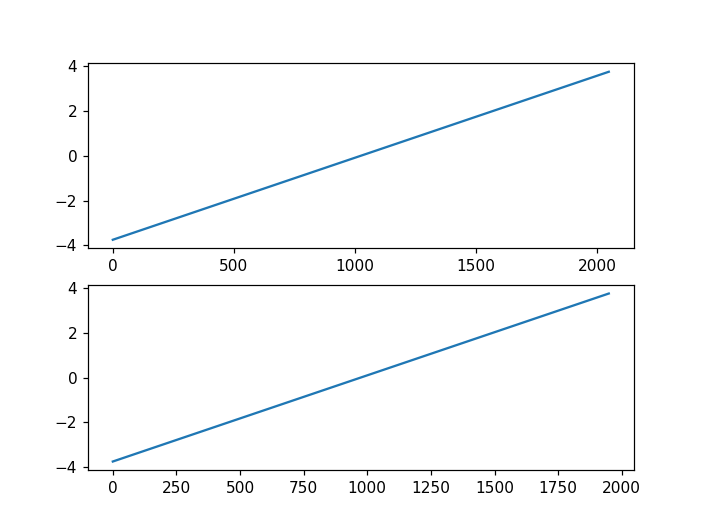

In [14]:
#let's visualize some things we've now done
fig,ax=plt.subplots(2,1)
ax[0].plot(k_u)
ax[1].plot(k_v)


In [15]:
# #determine the vector directions of u and v---------------------------------
n_hat = np.array([0,0,1])
print(R_c/np.linalg.norm(R_c))
v_hat = np.cross(n_hat, R_c)/np.linalg.norm(np.cross(n_hat, R_c))
u_hat = np.cross(v_hat, n_hat)/np.linalg.norm(np.cross(v_hat, n_hat))

print(v_hat)#almost y direction
print(u_hat)#almost x direction


[8.66025404e-01 5.68295411e-19 5.00000000e-01]
[-6.56211017e-19  1.00000000e+00  0.00000000e+00]
[ 1.00000000e+00  6.56211017e-19 -0.00000000e+00]


In [16]:
#Compute x and y unit vectors. x defined to lie along R_c.
#z = np.cross(vec[0], vec[-1]); z =z/np.linalg.norm(z)
print(R_c)
u_hat = (R_c-np.dot(R_c,n_hat)*n_hat)/\
        np.linalg.norm((R_c-np.dot(R_c,n_hat)*n_hat))
v_hat = np.cross(u_hat,n_hat)

print(v_hat)#negative y direction?
print(u_hat)#almost x direction


[8.66025404e+03 5.68295411e-15 5.00000000e+03]
[ 6.56211017e-19 -1.00000000e+00  0.00000000e+00]
[1.00000000e+00 6.56211017e-19 0.00000000e+00]


In [17]:
#we finish building the image plane dictionary by saving it
img_plane =\
    {
    'n_hat'     :   n_hat,
    'u_hat'     :   u_hat,
    'v_hat'     :   v_hat,
    'du'        :   du,
    'dv'        :   dv,
    'u'         :   u,
    'v'         :   v,
    'k_u'       :   k_u,
    'k_v'       :   k_v,
#    'pixel_locs':   pixel_locs # 3 x N_pixel array specifying x,y,z location
                               # of each pixel, not used in polar formating
    }

In [18]:
print(img_plane['n_hat'])
print(img_plane['u_hat'])
print(img_plane['v_hat'])
print(img_plane['du'])
print(img_plane['dv'])

[0 0 1]
[1.00000000e+00 6.56211017e-19 0.00000000e+00]
[ 6.56211017e-19 -1.00000000e+00  0.00000000e+00]
0.8367192339818982
0.8367192339818982


# Begin polar formatting

In [19]:
#Compute k_xi offset
#TODO: Figure out how k_ui compares to k_u+k_r*np.cos(psi)
psi = np.pi/2-np.arccos(np.dot(R_c,n_hat)/np.linalg.norm(R_c)) #np.pi/2 - graze at scene center?
k_ui = k_u + 4*np.pi*f_0/c*np.cos(psi)
#I'm not sure what this is for.
print(psi)
print(np.cos(psi))
print(4*np.pi*f_0/c*np.cos(psi))
#so we've shifted our range direction frequency space based on graze/squint at center


0.5235987755982987
0.8660254037844387
363.0110062810622


<IPython.core.display.Javascript object>


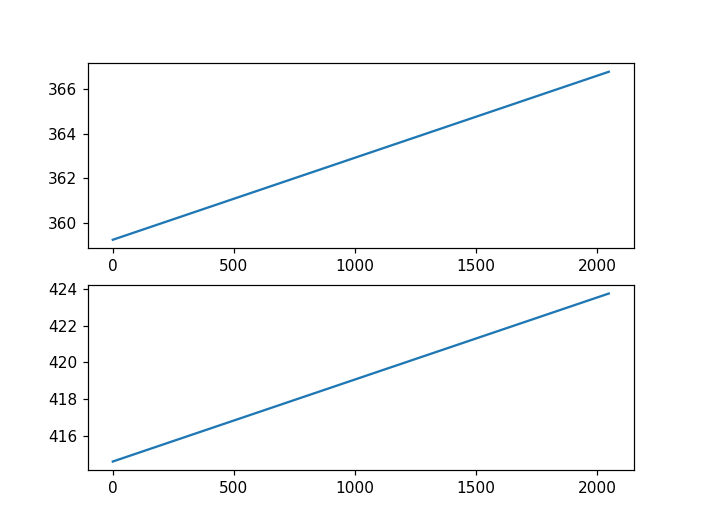

In [20]:
#display the new k_ui and the 
fig,ax = plt.subplots(2,1)
ax[0].plot(k_ui) 
#label this
ax[1].plot(k_r)
#label this 4*pi*freq/c


In [21]:
#Compute x and y unit vectors. x defined to lie along R_c.
#z = np.cross(vec[0], vec[-1]); z =z/np.linalg.norm(z)
#u_hat = (R_c-np.dot(R_c,n_hat)*n_hat)/\
#        np.linalg.norm((R_c-np.dot(R_c,n_hat)*n_hat))
#v_hat = np.cross(u_hat,n_hat)

#v_hat = np.cross(n_hat, R_c)/np.linalg.norm(np.cross(n_hat, R_c))
#u_hat = np.cross(v_hat, n_hat)/np.linalg.norm(np.cross(v_hat, n_hat))


#Compute r_hat, the diretion of k_r, for each pulse
r_norm = np.linalg.norm(pos,axis=1)
r_norm = np.array([r_norm]).T
r_norm = np.tile(r_norm,(1,3))
r_hat = pos/r_norm #unit vector of direction from scene center to platform at each pulse

In [22]:
#Convert to matrices to make projections easier
r_hat = np.asmatrix(r_hat)
u_hat = np.asmatrix([u_hat])
v_hat = np.asmatrix([v_hat])

#honestly not sure if this step does anything
#matrix multiplication works just fine if you have the shape already

k matrix shape:  (1, 2048)


<IPython.core.display.Javascript object>


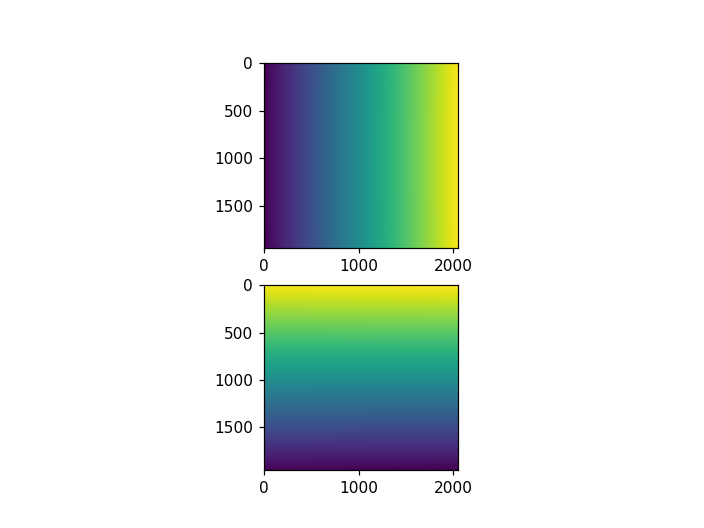

366.97605449440954 359.02889337657786
4.131341251950033 -4.131341251950033


In [23]:
#Compute kx and ky meshgrid
k_matrix= np.asmatrix(k_r)
print("k matrix shape: ", k_matrix.shape)
ku = r_hat*u_hat.T*k_matrix; ku = np.asarray(ku)
kv = r_hat*v_hat.T*k_matrix; kv = np.asarray(kv)

fig, ax= plt.subplots(2,1)
ax[0].imshow(ku)
ax[1].imshow(kv)
print(ku.max(), ku.min())
print(kv.max(), kv.min())




In [24]:
def taylor(nsamples, S_L=43):
    xi = np.linspace(-0.5, 0.5, nsamples)
    A = 1.0/np.pi*np.arccosh(10**(S_L*1.0/20))
    n_bar = int(2*A**2+0.5)+1
    sigma_p = n_bar/np.sqrt(A**2+(n_bar-0.5)**2)
    
    #Compute F_m
    m = np.arange(1,n_bar)
    n = np.arange(1,n_bar)
    F_m = np.zeros(n_bar-1)
    for i in m:
        num = 1
        den = 1
        for j in n:
            num = num*\
            (-1)**(i+1)*(1-i**2*1.0/sigma_p**2/(\
                            A**2+(j-0.5)**2))
            if i!=j:
                den = den*(1-i**2*1.0/j**2)
            
        F_m[i-1] = num/den
    
    w = np.ones(nsamples)
    for i in m:
        w += F_m[i-1]*np.cos(2*np.pi*i*xi)
    
    w = w/w.max()          
    return(w)

#Create taylor windows
win1 = taylor(int(phs.shape[1]), S_L = 20)
win2 = taylor(int(phs.shape[0]), S_L = 20)


<IPython.core.display.Javascript object>


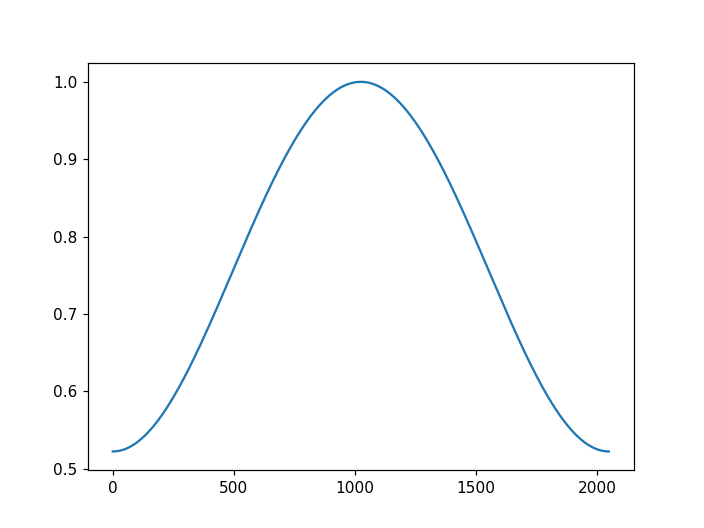

In [25]:
#show what taylor weighting looks like
plt.figure()
plt.plot(win1)



In [26]:
prnt=100

#Radially interpolate kx and ky data from polar raster
#onto evenly spaced kx_i and ky_i grid for each pulse
rad_interp = 0j*np.zeros([npulses,nu])
ky_new = np.zeros([npulses,nu])
for i in range(npulses):
    if prnt:
        if i%prnt==0:
            print('range interpolating for pulse %i'%(i+1))
    rad_interp[i,:] = np.interp(k_ui, ku[i,:], phs[i,:]*win1,
        left = 0, right = 0)
    ky_new[i,:] = np.interp(k_ui, ku[i,:], kv[i,:])  


range interpolating for pulse 1
range interpolating for pulse 101
range interpolating for pulse 201
range interpolating for pulse 301
range interpolating for pulse 401
range interpolating for pulse 501
range interpolating for pulse 601
range interpolating for pulse 701
range interpolating for pulse 801
range interpolating for pulse 901
range interpolating for pulse 1001
range interpolating for pulse 1101
range interpolating for pulse 1201
range interpolating for pulse 1301
range interpolating for pulse 1401
range interpolating for pulse 1501
range interpolating for pulse 1601
range interpolating for pulse 1701
range interpolating for pulse 1801
range interpolating for pulse 1901


<IPython.core.display.Javascript object>


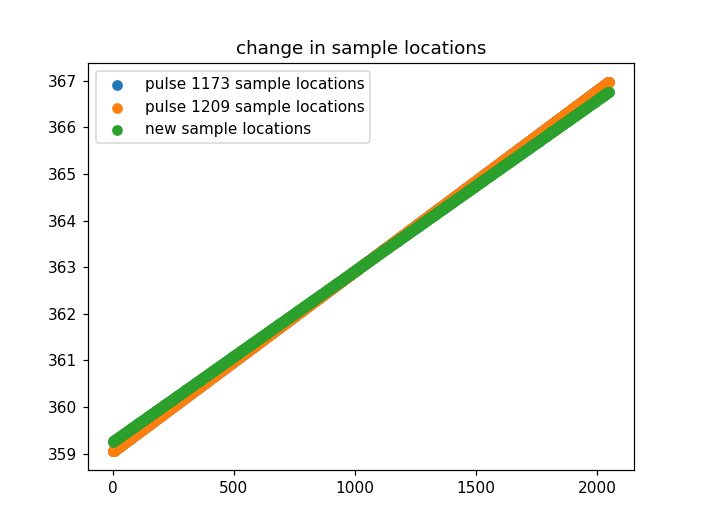

Text(0.5, 1.0, 'change in sample locations')

In [27]:
#this really needs an explanation of what interp is doing--------
#interpolation is used to resample the signal data at new sample locations
plt.figure()
pulsenum1,pulsenum2=np.random.randint(npulses,size=2)
plt.scatter(np.arange(len(ku[pulsenum1,:])), ku[pulsenum1,:], label='pulse %d sample locations' %pulsenum1) #
plt.scatter(np.arange(len(ku[pulsenum2,:])), ku[pulsenum2,:], label='pulse %d sample locations' %pulsenum2) #
plt.scatter(np.arange(len(k_ui)), k_ui, label='new sample locations') #
plt.legend() 
plt.title('change in sample locations')

#as you can see in the figure, interp is expanding the range of data while sampling at about the same density


<IPython.core.display.Javascript object>


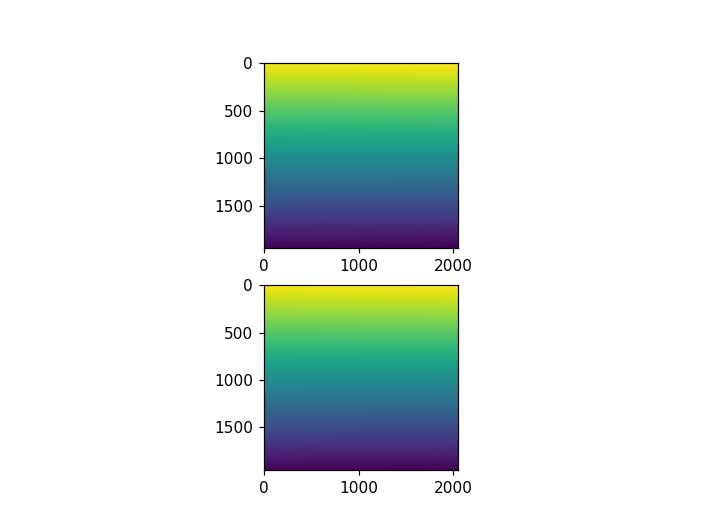

4.131341251950033 -4.131341251950033
4.129168946815527 -4.129168946815527


In [28]:
#also important to show kv vs ky_new
fig, ax= plt.subplots(2,1)
ax[0].imshow(kv)
ax[1].imshow(ky_new)
print(kv.max(), kv.min())
print(ky_new.max(), ky_new.min()) 


In [29]:
#Interpolate in along track direction to obtain polar formatted data
polar = 0j*np.zeros([nv,nu])
isSort = (ky_new[npulses//2, nu//2] < ky_new[npulses//2+1, nu//2])
#isSort seems like a flag to ensure u_hat is in the right direction, but we found earlier the codeisn't consistent with left vs right hand cross product
#TODO: fix left vs right cross product, figure out if it's a left looking vs right looking problem
if isSort:
    for i in range(nu):
        if prnt:
            if i%prnt==0:
                print('cross-range interpolating for sample %i'%(i+1))
        polar[:,i] = np.interp(k_v, ky_new[:,i], rad_interp[:,i]*win2,
            left = 0, right = 0)
else:
    for i in range(nu):
        if prnt:
            if i%prnt==0:
                print('cross-range interpolating for sample %i'%(i+1))
        polar[:,i] = np.interp(k_v, ky_new[::-1,i], 
            rad_interp[::-1,i]*win2, left = 0, right = 0)  
            
phs_polar=np.nan_to_num(polar)


cross-range interpolating for sample 1
cross-range interpolating for sample 101
cross-range interpolating for sample 201
cross-range interpolating for sample 301
cross-range interpolating for sample 401
cross-range interpolating for sample 501
cross-range interpolating for sample 601
cross-range interpolating for sample 701
cross-range interpolating for sample 801
cross-range interpolating for sample 901
cross-range interpolating for sample 1001
cross-range interpolating for sample 1101
cross-range interpolating for sample 1201
cross-range interpolating for sample 1301
cross-range interpolating for sample 1401
cross-range interpolating for sample 1501
cross-range interpolating for sample 1601
cross-range interpolating for sample 1701
cross-range interpolating for sample 1801
cross-range interpolating for sample 1901
cross-range interpolating for sample 2001


<IPython.core.display.Javascript object>


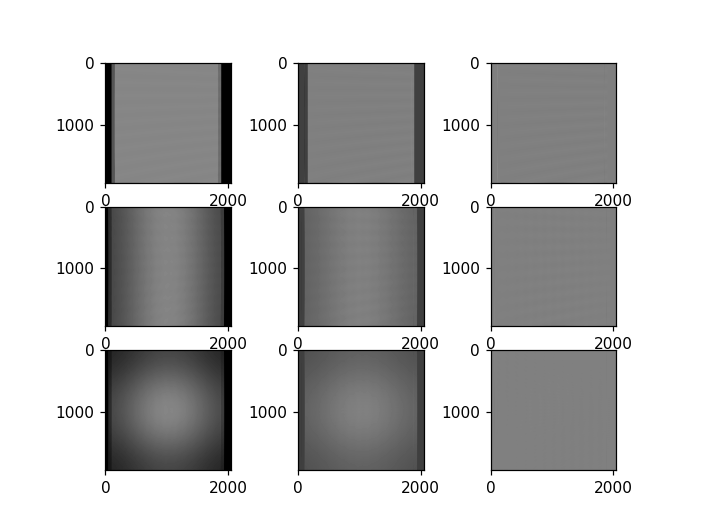

In [30]:
fig, ax= plt.subplots(3,3)
ax[0,0].imshow(np.abs(phs),cmap='gray')
ax[1,0].imshow(np.abs(rad_interp),cmap='gray')
ax[2,0].imshow(np.abs(polar),cmap='gray')

ax[0,1].imshow(np.real(phs),cmap='gray')
ax[1,1].imshow(np.real(rad_interp),cmap='gray')
ax[2,1].imshow(np.real(polar),cmap='gray')

ax[0,2].imshow(np.imag(phs),cmap='gray')
ax[1,2].imshow(np.imag(rad_interp),cmap='gray')
ax[2,2].imshow(np.imag(polar),cmap='gray')


<IPython.core.display.Javascript object>


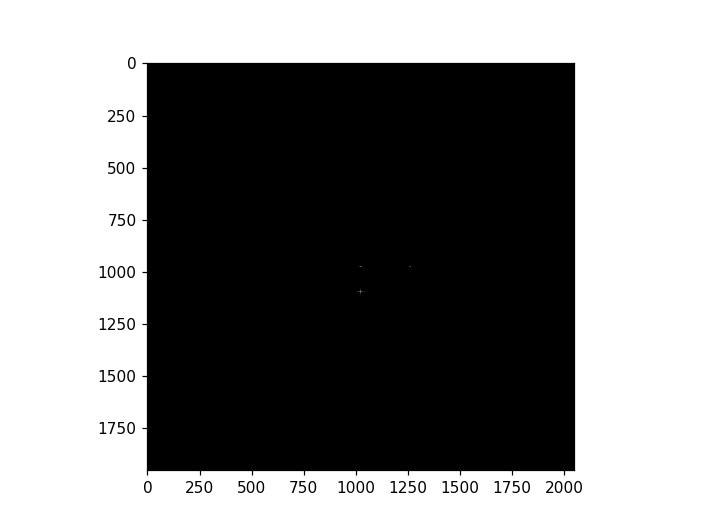

In [31]:
plt.figure()
shift1=np.fft.fftshift(phs_polar)
gmi=np.fft.fft2(shift1)
img=np.fft.ifftshift(gmi)
pre_scale=np.abs(img)

dB_scale=[-30,0]
img = 10*np.log10(np.abs(img)/np.abs(img).max())
img[img == -np.inf] = dB_scale[0]

plt.imshow(img,cmap=cm.Greys_r, vmin = dB_scale[0], vmax = dB_scale[-1])

